<a href="https://colab.research.google.com/github/hongrolee/Machine-Learning/blob/main/%EA%B2%B0%EC%A0%95%ED%8A%B8%EB%A6%AC%EC%97%90%EC%84%9C_%EC%B5%9C%EC%A0%81%EC%9D%98_%ED%8C%8C%EB%9D%BC%EB%AF%B8%ED%84%B0_%EC%B0%BE%EA%B8%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 최적의 파라미터 찾기 (교차 검증과 그리드 서치)
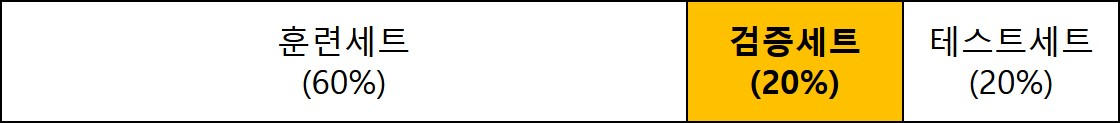

## 검증 세트 준비


### 데이터 읽어오기
- 와인데이터 : https://bit.ly/wine-date


In [22]:
import pandas as pd

wine = pd.read_csv('https://bit.ly/wine-date')

,alcohol,sugar,pH,class
0,9.4,1.9,3.51,0.0
1,9.8,2.6,3.20,0.0
2,9.8,2.3,3.26,0.0
3,9.8,1.9,3.16,0.0
4,9.4,1.9,3.51,0.0
...,...,...,...,...
6492,11.2,1.6,3.27,1.0
6493,9.6,8.0,3.15,1.0
6494,9.4,1.2,2.99,1.0
6495,12.8,1.1,3.34,1.0


### Data와 Target 분리

In [14]:
data = wine[['alcohol', 'sugar', 'pH']].to_numpy()
target = wine['class'].to_numpy()

### Train Data와 Test Data 분리
- train_test_split

In [15]:
from sklearn.model_selection import train_test_split

train_input, test_input, train_target, test_target = train_test_split(
    data, target, test_size=0.2, random_state=42)

### 검증 세트 준비

In [16]:
sub_input, val_input, sub_target, val_target = train_test_split(
    train_input, train_target, test_size=0.2, random_state=42)

### 검증 세트 확인

In [17]:
print(sub_input.shape, val_input.shape)

(4157, 3) (1040, 3)


### 모델 생성 후 평가

In [18]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=42)
dt.fit(sub_input, sub_target)

print(dt.score(sub_input, sub_target))
print(dt.score(val_input, val_target))

0.9971133028626413
0.864423076923077


## 교차 검증
- 검증세트를 떼어내어 평가과정을 반복한 후, 평균을 내어 최종 검증점수 획득
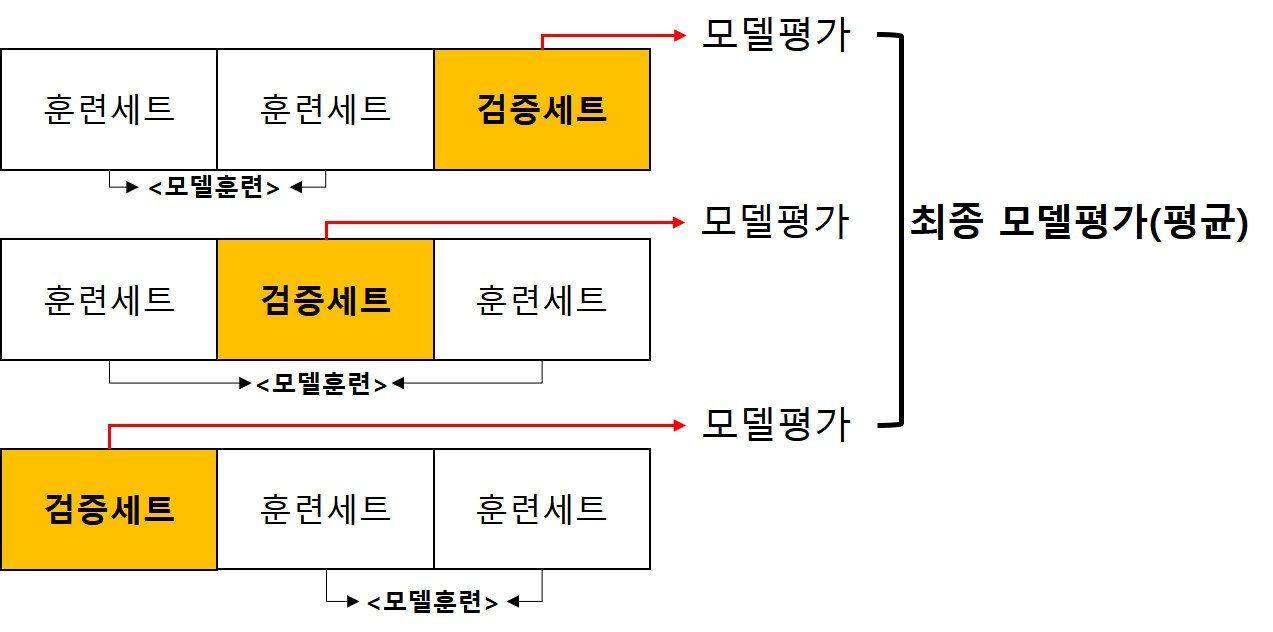

### cross_validate 활용

In [ ]:
from sklearn.model_selection import cross_validate

scores = cross_validate(dt, train_input, train_target)
print(scores)

{'fit_time': array([0.0074594 , 0.00722861, 0.00759482, 0.00742745, 0.0070498 ]), 'score_time': array([0.00114989, 0.00075364, 0.00071621, 0.00071669, 0.0007081 ]), 'test_score': array([0.86923077, 0.84615385, 0.87680462, 0.84889317, 0.83541867])}


### test_score 평균값 도출

In [ ]:
import numpy as np

print(np.mean(scores['test_score']))

0.855300214703487


### K-폴드 교차 검증기를 사용하는 경우

In [ ]:
from sklearn.model_selection import StratifiedKFold

scores = cross_validate(dt, train_input, train_target, cv=StratifiedKFold())
print(np.mean(scores['test_score']))

0.855300214703487


### 10-폴드 교차 검증의 경우

In [ ]:
splitter = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_validate(dt, train_input, train_target, cv=splitter)
print(np.mean(scores['test_score']))

0.8574181117533719


## 하이퍼파라미터 튜닝
- 결정트리의 매개변수 값을 바꿔가며 가장 좋은 성능의 모델을 찾는 과정

### 파라미터 생성
 - min_impurity_decrease : 노드의 정보이득x(노드의 샘플 수)/(전체 샘플 수)

In [ ]:
from sklearn.model_selection import GridSearchCV

params = {'min_impurity_decrease': [0.0001, 0.0002, 0.0003, 0.0004, 0.0005]}

### GridSearchCV 사용하여 학습
- 매개변수 : Decision Tree, parameter, n_jobs

In [ ]:
gs = GridSearchCV(DecisionTreeClassifier(random_state=42), params, n_jobs=-1)

In [ ]:
gs.fit(train_input, train_target)

GridSearchCV(cv=None, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=42,
                                              splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid={'min_impurity_decrease': [0.0001, 0.0002, 0.0003,
    

### 모델 평가
- best_estimator_ 파라미터에 의해 모델 추출
- score(train_input, train_target)

In [ ]:
dt = gs.best_estimator_
print(dt.score(train_input, train_target))

0.9615162593804117


### 최고 파라미터 확인
- best_params_

In [ ]:
print(gs.best_params_)

{'min_impurity_decrease': 0.0001}


In [ ]:
print(gs.cv_results_['mean_test_score'])

[0.86819297 0.86453617 0.86492226 0.86780891 0.86761605]


In [ ]:
best_index = np.argmax(gs.cv_results_['mean_test_score'])
print(gs.cv_results_['params'][best_index])

{'min_impurity_decrease': 0.0001}


In [ ]:
params = {'min_impurity_decrease': np.arange(0.0001, 0.001, 0.0001),
          'max_depth': range(5, 20, 1),
          'min_samples_split': range(2, 100, 10)
          }

In [ ]:
gs = GridSearchCV(DecisionTreeClassifier(random_state=42), params, n_jobs=-1)
gs.fit(train_input, train_target)

GridSearchCV(cv=None, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=42,
                                              splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid={'max_depth': range(5, 20),
                         'm

In [ ]:
print(gs.best_params_)

{'max_depth': 14, 'min_impurity_decrease': 0.0004, 'min_samples_split': 12}


In [ ]:
print(np.max(gs.cv_results_['mean_test_score']))

0.8683865773302731


## 랜덤 서치
- 연속된 매개변수 값을 자동으로 탐색하는 과정
- 지정된 획수만큼 샘플링하여 교차검증 수행
- 시스템 자원이 허락하는 만큼 탐색량 조절 가능

#### randint 와 uniform 테스트

In [ ]:
from scipy.stats import uniform, randint

In [ ]:
rgen = randint(0, 10)
rgen.rvs(10)


In [ ]:
np.unique(rgen.rvs(1000), return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([106,  91, 107,  92, 114, 109,  99,  89, 104,  89]))

In [ ]:
ugen = uniform(0, 1)
ugen.rvs(10)

array([0.0055196 , 0.26980899, 0.39549827, 0.65309536, 0.82688711,
       0.41958107, 0.89543513, 0.9064824 , 0.59886065, 0.6123146 ])

#### 파라미터 생성

In [ ]:
params = {'min_impurity_decrease': uniform(0.0001, 0.001),
          'max_depth': randint(20, 50),
          'min_samples_split': randint(2, 25),
          'min_samples_leaf': randint(1, 25),
          }

#### RandomizedSearchCV 적용하여 학습

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

gs = RandomizedSearchCV(DecisionTreeClassifier(random_state=42), params, 
                        n_iter=100, n_jobs=-1, random_state=42)
gs.fit(train_input, train_target)

RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features=None,
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    presort='deprecated',
                                                    random_state=42,
         

In [ ]:
print(gs.best_params_)

{'max_depth': 39, 'min_impurity_decrease': 0.00034102546602601173, 'min_samples_leaf': 7, 'min_samples_split': 13}


In [ ]:
print(np.max(gs.cv_results_['mean_test_score']))

0.8695428296438884


### 모델 평가

In [ ]:
dt = gs.best_estimator_

print(dt.score(test_input, test_target))

0.86
